- Convolutions
  - Local operations on neighborhoods
  - Translation invariance
    - localized patterns have an effect on the output regardless of their location in the image
  - Models with fewer parameters

- Conv1d for time series
- Conv2d for images
- Conv3d for volumes of videos

In [64]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import collections

from torchvision import datasets
from torchvision import transforms

In [65]:
conv = nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [66]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [67]:
data_path = f"../Chapter 7/"

In [68]:
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [69]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']

cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

In [70]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

- PyTorch will slide the convolution kernel within the input picture, getting width - kernel_width + 1 horizontal and vertical positions.
- For odd-sized kernels, this results in images that are one-half the convolution kernel's width (3 / 2 = 1, in our case) smaller on each side.

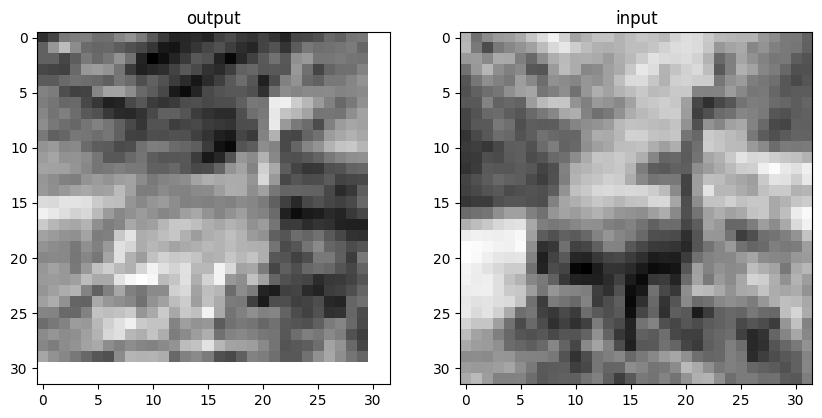

In [71]:
plt.figure(figsize=(10, 4.8))  
ax1 = plt.subplot(1, 2, 1)  
plt.title('output')  
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  
plt.imshow(img.mean(0), cmap='gray')  
plt.title('input')  
plt.show()

- Padding adds ghost pixels around the border that have value zero as far as the convolution is concerned
  - sizes of weight and bias don't change
  - helps us separate the matters of convolution and changing image sizes, so we have on less thing to remember
  - when we have more elaborate structures such as skip connections, we want the tensors before and after a few convolutions to be of compatible size so that we can add them or take differences

In [72]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

In [73]:
with torch.no_grad():
	conv.bias.zero_()

with torch.no_grad():
	conv.weight.fill_(1.0 / 9.0)

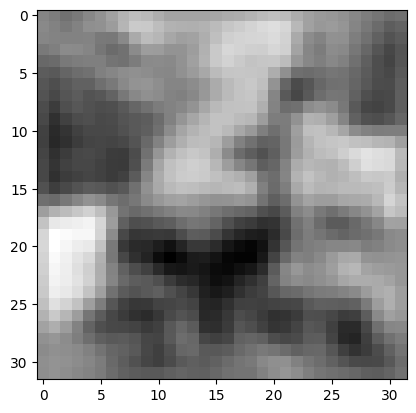

In [74]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [75]:
conv = nn.Conv2d(3, 1, kernel_size = 3, padding = 1)

with torch.no_grad():
	conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
									[-1.0, 0.0, 1.0],
									[-1.0, 0.0, 1.0]])
	conv.bias.zero_()

In [76]:
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

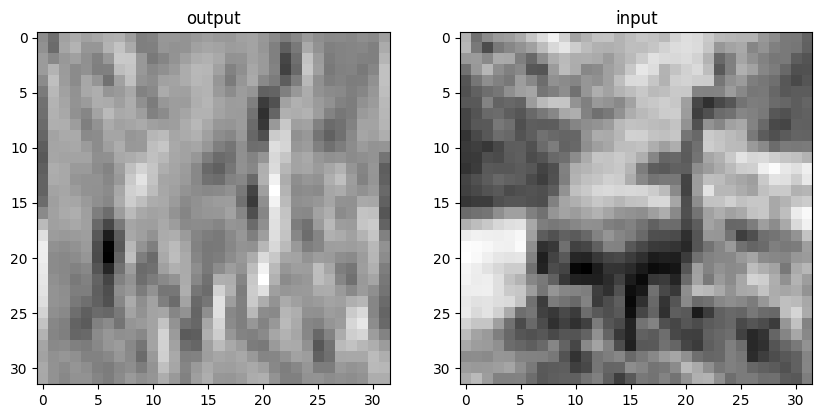

In [77]:
plt.figure(figsize=(10, 4.8))  
ax1 = plt.subplot(1, 2, 1)  
plt.title('output')  
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  
plt.imshow(img.mean(0), cmap='gray')  
plt.title('input')  
plt.show()

- Downsampling
  - Average the four pixels. The average pooling was a common approach early on but has fallen out of favor
  - Take the max of the four pixels. This approach, called max pooling, is currently the most commonly used approach, but it has a downside of discarding the other three-quarters of the data
  - Perform a strided convolution, where only every nth pixel is calculated. A 3x4 convolution with stride 2 still incorporates input from all pixels from the previous layer.  The literature shows promise for this approach, but has not yet supplanted max pooling

In [78]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

In [79]:
model = nn.Sequential(nn.Conv2d(3, 16, kernel_size = 3, padding = 1),
					nn.Tanh(),
					nn.MaxPool2d(2),
					nn.Conv2d(16, 8, kernel_size = 3, padding = 1),
			   		nn.Tanh(),
					nn.MaxPool2d(2),
					nn.Linear(8 * 8 * 8,  32),
					nn.Tanh(),
					nn.Linear(32, 2))

In [80]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [81]:
#model(img.unsqueeze(0))

In [82]:
class Net(nn.Module):
	def __init__(self):
		super().__init__()
		self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
		self.act1 = nn.Tanh()
		self.pool1 = nn.MaxPool2d(2)
		self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
		self.act2 = nn.Tanh()
		self.pool2 = nn.MaxPool2d(2)
		self.fc1 = nn.Linear(8 * 8 * 8, 32)
		self.act3 = nn.Tanh()
		self.fc2 = nn.Linear(32, 2)
	
	def forward(self, x):
		out = self.pool1(self.act1(self.conv1(x)))
		out = self.pool2(self.act2(self.conv2(out)))
		out = out.view(-1, 8 * 8 * 8)
		out = self.act3(self.fc1(out))
		out = self.fc2(out)
		return out

In [83]:
model = Net()
model(img.unsqueeze(0))

tensor([[-0.0191,  0.0288]], grad_fn=<AddmmBackward0>)

In [84]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [85]:
import torch.nn.functional as F

class Net(nn.Module):
	def __init__(self):
		super().__init__()
		self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
		self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
		self.fc1 = nn.Linear(8 * 8 * 8, 32)
		self.fc2 = nn.Linear(32, 2)

	def forward(self, x):
		out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
		out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
		out = out.view(-1, 8 * 8 * 8) 
		out = torch.tanh(self.fc1(out))
		out = self.fc2(out)
		return out

In [86]:
model = Net()
model(img.unsqueeze(0))

tensor([[-0.1336, -0.1353]], grad_fn=<AddmmBackward0>)

In [87]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
	for epoch in range(1, n_epochs + 1):
		loss_train = 0.0
		# Loop over dataset in batches
		for imgs, labels in train_loader:
			# Feed batch through model
			outputs = model(imgs)
			# Compute the loss
			loss = loss_fn(outputs, labels)
			
			# Zero gradients from last iteration
			optimizer.zero_grad()
			# Compute gradients of all parameters we want the network to learn
			loss.backward()
			# Update the model
			optimizer.step()

			# Sum losses over the epoch
			loss_train += loss.item()
			
		if epoch == 1 or epoch % 10 == 0:
			print('{} Epoch {}, Training loss {}'.format(
			datetime.datetime.now(), epoch,
			loss_train / len(train_loader)))

In [88]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size = 64, shuffle = True)

model = Net()
optimizer = optim.SGD(model.parameters(), lr = 1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(n_epochs = 100,
			  optimizer = optimizer,
			  model = model,
			  loss_fn = loss_fn,
			  train_loader = train_loader)

2023-10-19 13:25:21.581624 Epoch 1, Training loss 0.5578847728717099
2023-10-19 13:25:34.047944 Epoch 10, Training loss 0.3325587077315446
2023-10-19 13:25:47.941561 Epoch 20, Training loss 0.3004488119274188
2023-10-19 13:26:01.862202 Epoch 30, Training loss 0.2740854058106234
2023-10-19 13:26:15.685754 Epoch 40, Training loss 0.25050475922929255
2023-10-19 13:26:29.551345 Epoch 50, Training loss 0.2283349702977071
2023-10-19 13:26:43.341867 Epoch 60, Training loss 0.20950527422747034
2023-10-19 13:26:57.232481 Epoch 70, Training loss 0.19729480341931058
2023-10-19 13:27:11.054032 Epoch 80, Training loss 0.1836461688682532
2023-10-19 13:27:24.863571 Epoch 90, Training loss 0.17003599848527057
2023-10-19 13:27:38.627069 Epoch 100, Training loss 0.15730160811714305


In [89]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [90]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size = 64, shuffle = False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size = 64, shuffle = False)
all_acc_dict = collections.OrderedDict()

In [91]:
def validate(model, train_loader, val_loader):
	accdict = {}
	for name, loader in [("train", train_loader), ("val", val_loader)]:
		correct = 0
		total = 0

		# No longer want to update parameters
		with torch.no_grad():
			for imgs, labels in loader:
				imgs = imgs.to(device = device)
				labels = labels.to(device = device)

				outputs = model(imgs)
				_, predicted = torch.max(outputs, dim = 1)

				total += labels.shape[0]
				correct += int((predicted == labels).sum())
				
		print("Accuracy {}: {:.2f}".format(name , correct / total))
		accdict[name] = correct / total
	return accdict

In [92]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
	for epoch in range(1, n_epochs + 1):
		loss_train = 0.0
		# Loop over dataset in batches
		for imgs, labels in train_loader:
			imgs = imgs.to(device = device)
			labels = labels.to(device = device)
			# Feed batch through model
			outputs = model(imgs)
			# Compute the loss
			loss = loss_fn(outputs, labels)
			# Zero gradients from last iteration
			optimizer.zero_grad()
			# Compute gradients of all parameters we want the network to learn
			loss.backward()
			# Update the model
			optimizer.step()

			# Sum losses over the epoch
			loss_train += loss.item()
			
		if epoch == 1 or epoch % 10 == 0:
			print('{} Epoch {}, Training loss {}'.format(
			datetime.datetime.now(), epoch,
			loss_train / len(train_loader)))

In [93]:
model = Net().to(device = device)
optimizer = optim.SGD(model.parameters(), lr = 1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(n_epochs = 100,
			  optimizer = optimizer,
			  model = model,
			  loss_fn = loss_fn,
			  train_loader = train_loader)

all_acc_dict["baseline"] = validate(model, train_loader, val_loader)

2023-10-19 13:27:38.931704 Epoch 1, Training loss 0.5726538446678477
2023-10-19 13:27:41.058635 Epoch 10, Training loss 0.3356330185938793
2023-10-19 13:27:43.374739 Epoch 20, Training loss 0.30214247762397595
2023-10-19 13:27:45.632789 Epoch 30, Training loss 0.27810417457371
2023-10-19 13:27:47.872823 Epoch 40, Training loss 0.25549891410739556
2023-10-19 13:27:50.108853 Epoch 50, Training loss 0.23470484213844225
2023-10-19 13:27:52.322864 Epoch 60, Training loss 0.21604725016150506
2023-10-19 13:27:54.536875 Epoch 70, Training loss 0.19895848731516272
2023-10-19 13:27:56.760894 Epoch 80, Training loss 0.1834789708636369
2023-10-19 13:27:58.978908 Epoch 90, Training loss 0.16909517725087275
2023-10-19 13:28:01.210935 Epoch 100, Training loss 0.15514584443276855
Accuracy train: 0.93
Accuracy val: 0.89


In [94]:
data_path = f"./"
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

In [95]:
loaded_model = Net()
loaded_model.load_state_dict(torch.load(data_path + 'birds_vs_airplanes.pt'))

<All keys matched successfully>

In [96]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [97]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
	for epoch in range(1, n_epochs + 1):
		loss_train = 0.0
		
		for imgs, labels in train_loader:
			imgs = imgs.to(device = device)
			labels = labels.to(device = device)

			outputs = model(imgs)
			loss = loss_fn(outputs, labels)

			optimizer.zero_grad()
			loss.backward()
			optimizer.step()

			loss_train += loss.item()
		if epoch == 1 or epoch % 10 == 0:
			print('{} Epoch {}, Training loss {}'.format(
			datetime.datetime.now(), epoch,
			loss_train / len(train_loader)))


In [98]:
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(n_epochs = 100,
				optimizer = optimizer,
				model = model,
				loss_fn = loss_fn,
				train_loader = train_loader)

2023-10-19 13:28:01.629353 Epoch 1, Training loss 0.555296175608969
2023-10-19 13:28:03.683218 Epoch 10, Training loss 0.349562748886977
2023-10-19 13:28:05.922251 Epoch 20, Training loss 0.29957899859376774
2023-10-19 13:28:08.150274 Epoch 30, Training loss 0.2706017107910411
2023-10-19 13:28:10.358280 Epoch 40, Training loss 0.24958268970630731
2023-10-19 13:28:12.563282 Epoch 50, Training loss 0.23124489558350508
2023-10-19 13:28:14.753270 Epoch 60, Training loss 0.21471665918257585
2023-10-19 13:28:16.946262 Epoch 70, Training loss 0.19917119194747537
2023-10-19 13:28:19.163275 Epoch 80, Training loss 0.18444065317796293
2023-10-19 13:28:21.362272 Epoch 90, Training loss 0.17035986862744495
2023-10-19 13:28:23.562270 Epoch 100, Training loss 0.15627696929843563


In [99]:
# PyTorch will attempt to load the weight on the same device it was saved from. Weights on the GPU will be restored to the GPU
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load(data_path + 'birds_vs_airplanes.pt', map_location=device))

<All keys matched successfully>

- width
  - the number of neurons per layer, or channels per convolution
  - increase width by specifying a large number of output channels

In [100]:
class NetWidth(nn.Module):
	def __init__(self, n_chans1 = 32):
		super().__init__()
		self.n_chans1 = n_chans1
		self.conv1 = nn.Conv2d(3, n_chans1, kernel_size = 3, padding = 1)
		self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size = 3, padding = 1)

		self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
		self.fc2 = nn.Linear(32, 2)
	
	def forward(self, x):
		out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
		out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
		out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
		out = torch.tanh(self.fc1(out))
		out = self.fc2(out)
		return out

In [101]:
model2 = NetWidth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model2.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model2,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

all_acc_dict["width"] = validate(model2, train_loader, val_loader)

2023-10-19 13:28:23.856469 Epoch 1, Training loss 0.5362597521702954
2023-10-19 13:28:26.070480 Epoch 10, Training loss 0.31083890102851164
2023-10-19 13:28:28.528712 Epoch 20, Training loss 0.27226091750488157
2023-10-19 13:28:30.987944 Epoch 30, Training loss 0.24449090014217764
2023-10-19 13:28:33.447178 Epoch 40, Training loss 0.21573129609511915
2023-10-19 13:28:35.873381 Epoch 50, Training loss 0.1892390107368208
2023-10-19 13:28:38.457728 Epoch 60, Training loss 0.16615754408631356
2023-10-19 13:28:40.994030 Epoch 70, Training loss 0.14515228650182677
2023-10-19 13:28:43.443255 Epoch 80, Training loss 0.12505105116469845
2023-10-19 13:28:45.904489 Epoch 90, Training loss 0.1060754890749409
2023-10-19 13:28:48.360720 Epoch 100, Training loss 0.0884345245256925
Accuracy train: 0.96
Accuracy val: 0.90


In [102]:
sum(p.numel() for p in model2.parameters())

38386

- optimization, when we need to loss to decrease on the training set
- generalization, when the model has to wokr not only on the training set but also on data it has not seen before

- Regularization
  - L2 (weight decay) : sum of squares of all weights in the model
    - -2 * lambda * w_i
    - decreases each weight by an amount proportional to its current value during the optimization
  - L1 : the sum of the absolute values of all weights in the model

In [103]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn, train_loader):
	for epoch in range(1, n_epochs + 1):
		loss_train = 0.0
		for imgs, labels in train_loader:
			imgs = imgs.to(device = device)
			labels = labels.to(device = device)

			outputs = model(imgs)
			loss = loss_fn(outputs, labels)

			l2_lambda = 0.001
			l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
			loss = loss + l2_lambda * l2_norm

			optimizer.zero_grad()
			loss.backward()
			optimizer.step()

			loss_train += loss.item()
		if epoch == 1 or epoch % 10 == 0:
			print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, loss_train / len(train_loader)))


In [104]:
model3 = Net().to(device=device)
optimizer = optim.SGD(model3.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop_l2reg(
    n_epochs = 100,
    optimizer = optimizer,
    model = model3,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["l2 reg"] = validate(model3, train_loader, val_loader)

2023-10-19 13:28:48.888803 Epoch 1, Training loss 0.6030529621680072
2023-10-19 13:28:51.993622 Epoch 10, Training loss 0.3631173164411715
2023-10-19 13:28:55.451762 Epoch 20, Training loss 0.32136367441742286
2023-10-19 13:28:58.913906 Epoch 30, Training loss 0.2971467403279748
2023-10-19 13:29:02.295977 Epoch 40, Training loss 0.27924542299881105
2023-10-19 13:29:05.678048 Epoch 50, Training loss 0.26565534066242774
2023-10-19 13:29:09.081139 Epoch 60, Training loss 0.25375688920734796
2023-10-19 13:29:12.523264 Epoch 70, Training loss 0.24257096116709861
2023-10-19 13:29:15.933361 Epoch 80, Training loss 0.23232037792350077
2023-10-19 13:29:19.313430 Epoch 90, Training loss 0.22280452158420708
2023-10-19 13:29:22.696502 Epoch 100, Training loss 0.21419607140835684
Accuracy train: 0.92
Accuracy val: 0.88


- SGD optimizer in PyTorch already performs weight decay during the update

- Dropout
  - zero out a random fraction of outputs from neurons across the network, where the randomization happens at each training iteration
  - generates slightly different models with different neuron topologies at each iteration, giving neurons in the model less chance to coordinate in the memorization process that happens during overfitting
  - active during training and is assigned a probability of 0 during evaluation

In [105]:
class NetDropout(nn.Module):
	def __init__(self, n_chans1 = 32):
		super().__init__()
		self.n_chans1 = n_chans1
		self.conv1 = nn.Conv2d(3, n_chans1, kernel_size = 3, padding = 1)
		self.conv1_dropout = nn.Dropout2d(p = 0.4)
		self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size = 3, padding = 1)
		self.conv2_dropout = nn.Dropout2d(p = 0.4)
		self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
		self.fc2 = nn.Linear(32, 2)

	def forward(self, x):
		out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
		out = self.conv1_dropout(out)
		out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
		out = self.conv2_dropout(out)
		out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
		out = torch.tanh(self.fc1(out))
		out = self.fc2(out)

		return out


In [106]:
model4 = NetDropout(n_chans1=32).to(device=device)
optimizer = optim.SGD(model4.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model4,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["dropout"] = validate(model4, train_loader, val_loader)

2023-10-19 13:29:23.117143 Epoch 1, Training loss 0.5673464487312706
2023-10-19 13:29:25.535339 Epoch 10, Training loss 0.3813974975021022
2023-10-19 13:29:28.225783 Epoch 20, Training loss 0.3462357212593601
2023-10-19 13:29:30.912222 Epoch 30, Training loss 0.33071836601397037
2023-10-19 13:29:33.564630 Epoch 40, Training loss 0.31244144375157207
2023-10-19 13:29:36.127958 Epoch 50, Training loss 0.30150415458876617
2023-10-19 13:29:38.690285 Epoch 60, Training loss 0.2875221955358602
2023-10-19 13:29:41.252611 Epoch 70, Training loss 0.27521069044140495
2023-10-19 13:29:43.821944 Epoch 80, Training loss 0.2665165186307992
2023-10-19 13:29:46.393279 Epoch 90, Training loss 0.25685551980878135
2023-10-19 13:29:48.955606 Epoch 100, Training loss 0.2498239821689144
Accuracy train: 0.90
Accuracy val: 0.87


- Batch Normalization
  - rescale the inputs to the activations of the network so that minibatches have a certain desirable distribution
  - helps avoid the inputs to activation functions being too far into the saturated portion of the function, thereby killing gradients and slowing training
  - shifts and scales an intermediate input using the mean and standard deviation collected at that intermediate location over the samples of the minibatch
  - eliminates the need for dropout

In [107]:
class NetBatchNorm(nn.Module):
	def __init__(self, n_chans1 = 32):
		super().__init__()
		self.n_chans1 = n_chans1
		self.conv1 = nn.Conv2d(3, n_chans1, kernel_size = 3, padding = 1)
		self.conv1_batchnorm = nn.BatchNorm2d(num_features = n_chans1)
		self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size = 3, padding = 1)
		self.conv2_batchnorm = nn.BatchNorm2d(num_features = n_chans1 // 2)
		self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
		self.fc2 = nn.Linear(32, 2)

	def forward(self, x):
		out = self.conv1_batchnorm(self.conv1(x))
		out = F.max_pool2d(torch.tanh(out), 2)
		out = self.conv2_batchnorm(self.conv2(out))
		out = F.max_pool2d(torch.tanh(out), 2)
		out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
		out = torch.tanh(self.fc1(out))
		out = self.fc2(out)

		return out

In [108]:
model5 = NetBatchNorm(n_chans1=32).to(device=device)
optimizer = optim.SGD(model5.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model5,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["batch_norm"] = validate(model5, train_loader, val_loader)

2023-10-19 13:29:49.417086 Epoch 1, Training loss 0.4687196044785202
2023-10-19 13:29:52.083508 Epoch 10, Training loss 0.2733279365547903
2023-10-19 13:29:55.052203 Epoch 20, Training loss 0.20848285701054675
2023-10-19 13:29:58.008888 Epoch 30, Training loss 0.1552167494253368
2023-10-19 13:30:00.920531 Epoch 40, Training loss 0.10977430359288386
2023-10-19 13:30:03.787135 Epoch 50, Training loss 0.0720713091005755
2023-10-19 13:30:06.660744 Epoch 60, Training loss 0.04812623139257264
2023-10-19 13:30:09.527347 Epoch 70, Training loss 0.03867383335663634
2023-10-19 13:30:12.416971 Epoch 80, Training loss 0.018452640425615535
2023-10-19 13:30:15.311599 Epoch 90, Training loss 0.011498860971836052
2023-10-19 13:30:18.205227 Epoch 100, Training loss 0.0075813115635222405
Accuracy train: 0.99
Accuracy val: 0.89


- a long chain of multiplications will tend to make the contriution of the parameter to the gradient vanish, leading to ineffective training of that layer since that parameter and other like it won't be properly updated


In [109]:
class NetDepth(nn.Module):
	def __init__(self, n_chans1 = 32):
		super().__init__()
		self.n_chans1 = n_chans1
		self.conv1 = nn.Conv2d(3, n_chans1, kernel_size = 3 , padding = 1)
		self.conv2 = nn.Conv2d(n_chans1,  n_chans1 // 2, kernel_size = 3, padding = 1)
		self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2, kernel_size = 3, padding = 1)
		self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
		self.fc2 = nn.Linear(32, 2)

	def forward(self, x):
		out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
		out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
		# skip connection
		out1 = out
		out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
		out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
		out = torch.relu(self.fc1(out))
		out = self.fc2(out)

		return out

In [110]:
model6 = NetDepth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model6.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model6,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["depth"] = validate(model6, train_loader, val_loader)

2023-10-19 13:30:18.672549 Epoch 1, Training loss 0.6424840688705444
2023-10-19 13:30:21.152801 Epoch 10, Training loss 0.32291410151560596
2023-10-19 13:30:23.896292 Epoch 20, Training loss 0.2824462880943991
2023-10-19 13:30:26.633778 Epoch 30, Training loss 0.2515950942305243
2023-10-19 13:30:29.381273 Epoch 40, Training loss 0.22337720358068017
2023-10-19 13:30:32.088732 Epoch 50, Training loss 0.19648210633142738
2023-10-19 13:30:34.784179 Epoch 60, Training loss 0.17100827652177994
2023-10-19 13:30:37.475623 Epoch 70, Training loss 0.14581111752113718
2023-10-19 13:30:40.159060 Epoch 80, Training loss 0.12159246339160167
2023-10-19 13:30:42.847501 Epoch 90, Training loss 0.09674727655709929
2023-10-19 13:30:45.550956 Epoch 100, Training loss 0.07799379124193434
Accuracy train: 0.95
Accuracy val: 0.89


- identity mapping
  - using the ouput of the first activations as inputs to the last, in addition to the standard feed-forward path
- skip connections
  - creates a direct path from the deeper parameters to the loss
  - makes the parameters contribution to the gradient of the loss more direct, as partial derivatives of the loss with respect to those parameters have a chance no to be multipled by a long chain of other operations

In [111]:
class ResBlock(nn.Module):
	def __init__(self, n_chans):
		super(ResBlock, self).__init__()
		self.conv = nn.Conv2d(n_chans, n_chans, kernel_size = 3, padding = 1, bias = False)
		self.batch_norm = nn.BatchNorm2d(num_features = n_chans)
		# initializes with normal random elements with standard deviation as computed in the ResNet paper
		torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity = 'relu')
		torch.nn.init.constant_(self.batch_norm.weight, 0.5)
		torch.nn.init.zeros_(self.batch_norm.bias)
	
	def forward(self, x):
		out = self.conv(x)
		out = self.batch_norm(out)
		out = torch.relu(out)
		
		return out + x

In [112]:
class NetResDeep(nn.Module):
	def __init__(self, n_chans1 = 32, n_blocks = 10) -> None:
		super().__init__()
		self.n_chans1 = n_chans1
		self.conv1 = nn.Conv2d(3, n_chans1, kernel_size = 3, padding = 1)
		self.resblocks = nn.Sequential(*(n_blocks * [ResBlock(n_chans = n_chans1)]))
		self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
		self.fc2 = nn.Linear(32, 2)
	
	def forward(self, x):
		out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
		out = self.resblocks(out)
		out = F.max_pool2d(out, 2)
		out = out.view(-1, 8 * 8 * self.n_chans1)
		out = torch.relu(self.fc1(out))
		out = self.fc2(out)

		return out


In [113]:
model7 = NetResDeep(n_chans1 = 32, n_blocks = 100).to(device = device)
optimizer = optim.SGD(model7.parameters(), lr = 3e-3)
loss_fn = nn.CrossEntropyLoss()

training_loop(n_epochs = 100,
			  optimizer = optimizer,
			  model = model7,
			  loss_fn = loss_fn,
			  train_loader = train_loader)
all_acc_dict["res deep"] = validate(model7, train_loader, val_loader)

2023-10-19 13:30:52.372912 Epoch 1, Training loss 1.504610239889971
2023-10-19 13:31:50.807974 Epoch 10, Training loss 0.3287470200259215
2023-10-19 13:32:55.742939 Epoch 20, Training loss 0.25748225405907177
2023-10-19 13:34:00.505746 Epoch 30, Training loss 0.21982509861136698
2023-10-19 13:35:05.356635 Epoch 40, Training loss 0.20634576184734418
2023-10-19 13:36:10.200612 Epoch 50, Training loss 0.11632336787642188
2023-10-19 13:37:15.087533 Epoch 60, Training loss 0.1362922590961502
2023-10-19 13:38:19.957438 Epoch 70, Training loss 0.117920397537624
2023-10-19 13:39:24.720247 Epoch 80, Training loss 0.08397230427641018
2023-10-19 13:40:29.893427 Epoch 90, Training loss 0.0631325118403858
2023-10-19 13:41:34.799365 Epoch 100, Training loss 0.04208720598375769
Accuracy train: 0.97
Accuracy val: 0.86


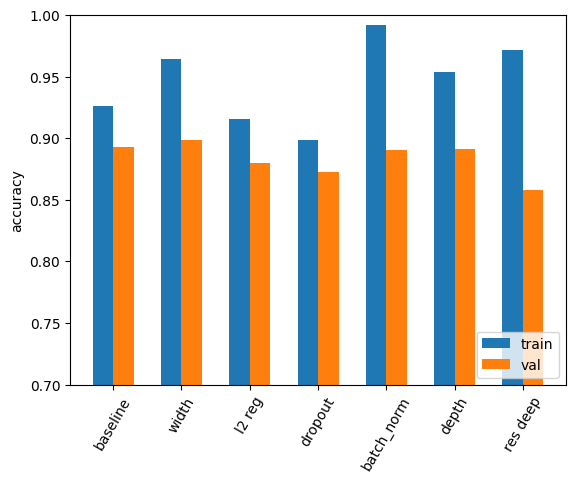

In [114]:
import numpy as np

trn_acc = [v['train'] for k, v in all_acc_dict.items()]
val_acc = [v['val'] for k, v in all_acc_dict.items()]

width =0.3
plt.bar(np.arange(len(trn_acc)), trn_acc, width=width, label='train')
plt.bar(np.arange(len(val_acc))+ width, val_acc, width=width, label='val')
plt.xticks(np.arange(len(val_acc))+ width/2, list(all_acc_dict.keys()),
           rotation=60)
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.ylim(0.7, 1)
plt.savefig('accuracy_comparison.png', bbox_inches='tight')
plt.show()

- weight decay and dropout regulariztions have a much narrower gap between the two accuracies
- batch norm, which serves as a convergence helper, trains the network to nearly 100% training accuracy